<center><h1>1-e: Transformers</h1></center>
<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>


**We have all the question answered with details in the report.**

In this notebook, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.

To get a gist of what is required to make a transformer work in practice, have a look at the [DeiT and CaiT codebase](https://github.com/facebookresearch/deit).

This notebook is a simplified version of the excellent [Timm library](https://github.com/rwightman/pytorch-image-models).

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image
from tqdm import tqdm
!pip install torchmetrics
import torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 45.1 MB/s eta 0:00:00


Let's load the MNIST dataset:

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:11<00:00, 901kB/s] 


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 136kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.29MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



... and visualize!

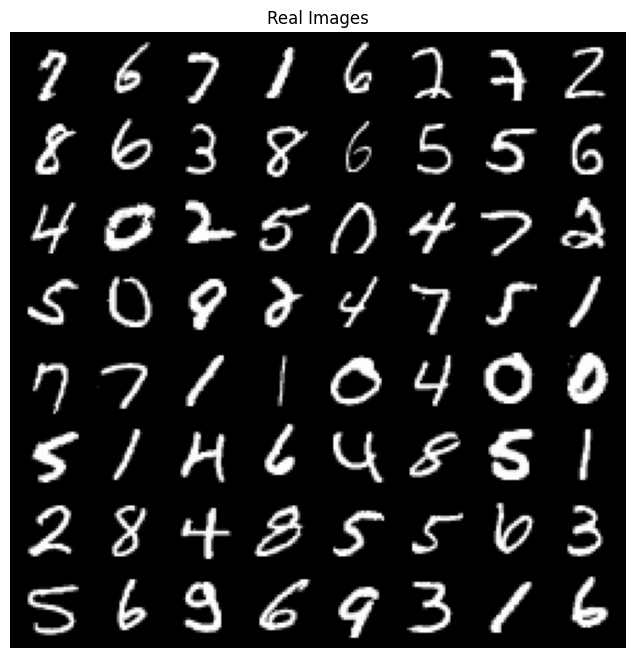

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

# Here is the general architecture of the ViT model
## The architecture includes:
- A step for splitting the image into disjoint patches with a linear projection of the patches
- Positional encoding to capture the absolute spatial information of each patch in the image
- The addition of a "[CLS]" token, initialized randomly and learned during training
- A transformer encoder that learns the representation of each token
- A classification head that performs class prediction from the re-embedded [CLS] token at the output of the encoder

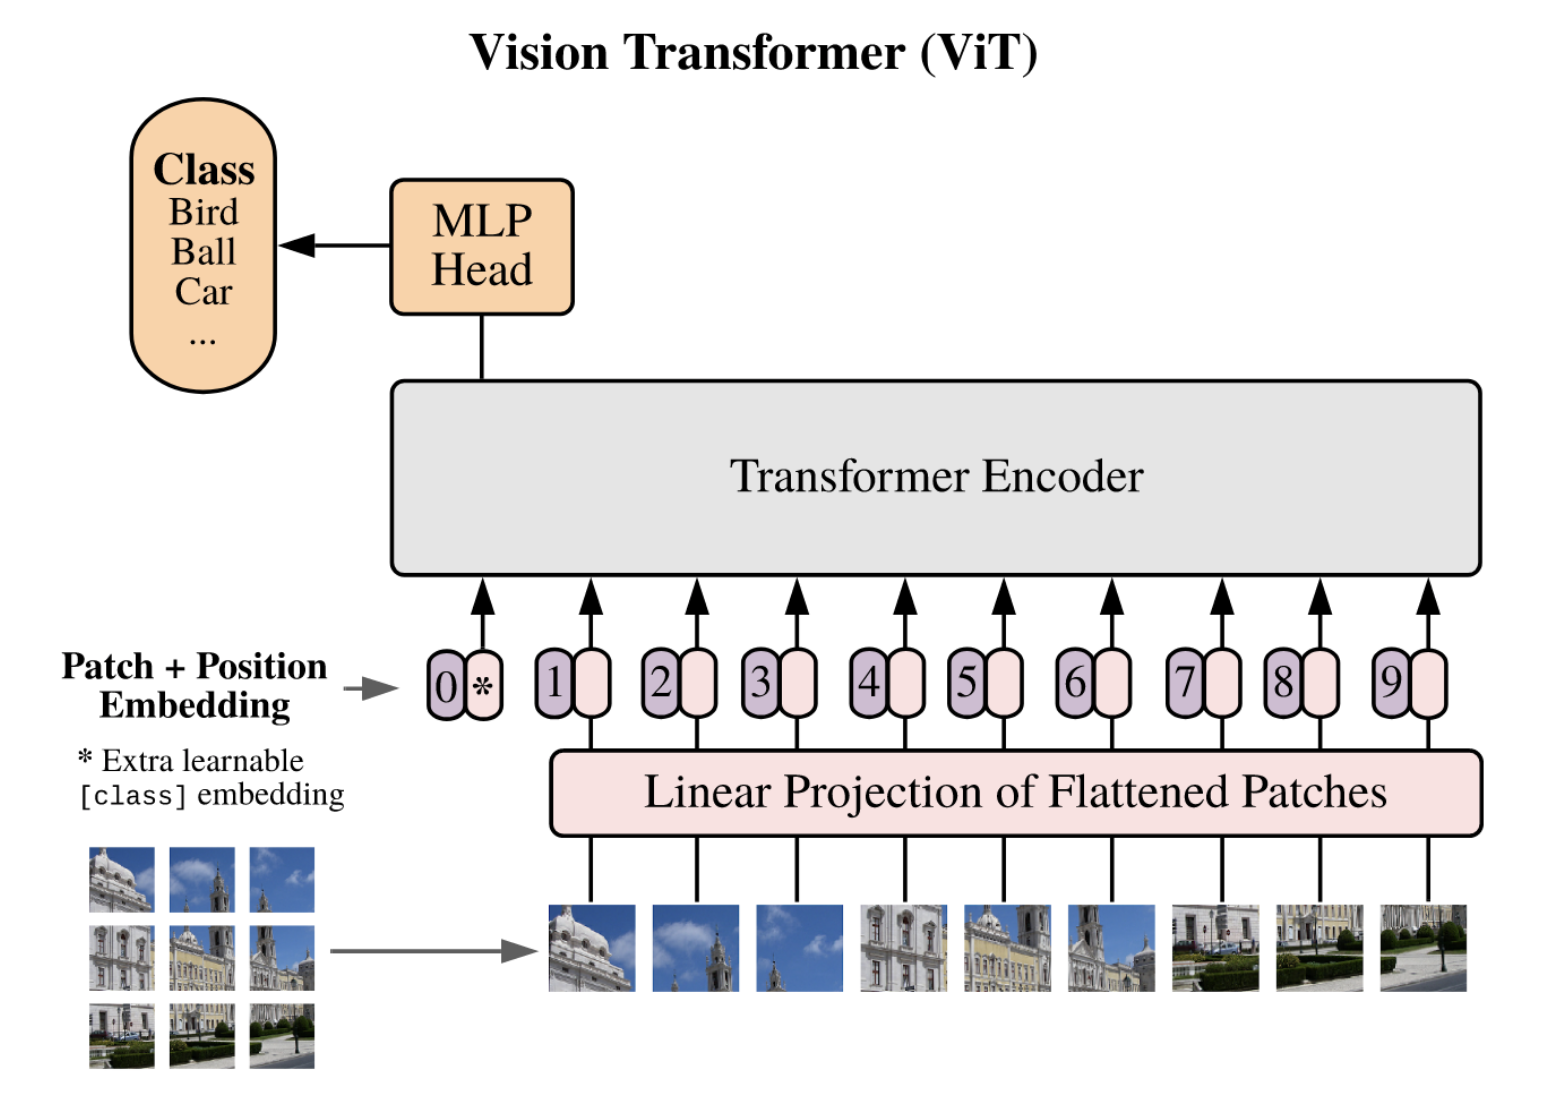

# Linear Projection of flattened patches

**Q1**:
First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a specific 2d convolution to play the role of the so-called "Linear Projection" on the image above and process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

In [ ]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
    super().__init__()
    ## TODO
    self.projection = nn.Conv2d(in_chan,embed_dim,kernel_size=patch_size,stride=patch_size)

  def forward(self, x):
    """
    x: torch.Tensor -> (B, in_chan, H_in, W_in)
    """
    x = self.projection(x) # (B,C=embed_dim,H=H_in/patch_size,W=W_in/patch_size)
    # print(x.shape)

    B, C, H, W = x.shape
    ## TODO
    x=x.reshape(B,C,H*W).permute(0,2,1)

    # x.shape() -> B, N, C
    return x


In [ ]:
PatchEmbed(in_chan=2, patch_size=7, embed_dim=128)(torch.randn(32,2,28,28)).shape

torch.Size([32, 16, 128])

# Transformer encoder

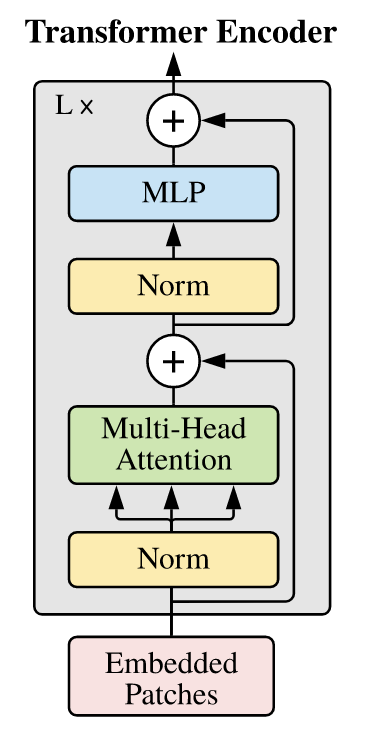

## Q2: MLP

Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()
    self.seq=nn.Sequential(
        nn.Linear(in_features, hid_features),
        nn.GELU(),
        nn.Linear(hid_features, in_features)
    )

    # TODO

  def forward(self, x):
    # TODO
    x=self.seq(x)
    return x


MLP(128, 512)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

## Q3: Self-attention

Now we are going to build the famous **Self-Attention**.
- What is the main feature of self-attention, especially compared to its convolutional counterpart. What is its main challenge in terms of computation/memory?
- At first, we are going to only consider the simple case of one head. Write the equations and complete the following code. And don't forget a final linear projection at the end!




**Answers in the report.**

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, embed_dim):
    super().__init__()

    # TODO
    self.q=nn.Linear(embed_dim,embed_dim,bias=False)
    self.k=nn.Linear(embed_dim,embed_dim,bias=False)
    self.v=nn.Linear(embed_dim,embed_dim,bias=False)
    self.scale=(embed_dim)**0.5




  def forward(self, x):
    """
    B : batch size
    N : nombre d'embedding = nombre de patch d'image
    C : taille d'un embedding
    """
    B, N, C = x.shape

    # TODO: compute the Q, K, V
    q = self.q(x) # B,N,C
    k = self.k(x) # B,N,C
    v = self.v(x) # B,N,C

    # TODO: compute the attention matrix using Q and K
    attention = q@k.transpose(1,2)/self.scale
    attention=F.softmax(attention,dim=-1) # B,N,N


    # TODO: compute the final version using the attention,
    # V, and the final projection
    x = attention@v # B,N,C

    return x


SelfAttention(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q4 : Multi-head self-attention

Now we need to build a Multi-Heads Self-Attention.
- Write the equations and complete the following code to build a Multi-Heads Self-Attention.
- The total embedding size will be shared equally among all heads.

**Answers in the report.**

In [ ]:
class MultiHeadsSelfAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()

    head_dim = embed_dim//num_heads
    self.scale = head_dim ** -0.5
    self.num_heads = num_heads

    self.q=nn.Linear(embed_dim,embed_dim,bias=False)
    self.k=nn.Linear(embed_dim,embed_dim,bias=False)
    self.v=nn.Linear(embed_dim,embed_dim,bias=False)
    self.projection = nn.Linear(embed_dim,embed_dim)

  def forward(self, x):
    B, N, C = x.shape



    q = self.q(x)
    k = self.k(x)
    v = self.v(x)



    # You need to reshape and permute dimension in a certain manner
    # so that each head (C // num_heads) interact
    # only with its dimensions and not other heads.
    num_heads=self.num_heads
    dk=C//num_heads # dim of k for each head
    dv=C//num_heads # dim of v for each head


    # Try to write at each operation the shape of the tensor if you
    # feel confused.
    q=q.reshape(B,N,num_heads,dk).transpose(1,2) #(B,num_heads,N,C//num_heads)
    k=k.reshape(B,N,num_heads,dk).transpose(1,2) #(B,num_heads,N,C//num_heads)
    v=v.reshape(B,N,num_heads,dv).transpose(1,2) #(B,num_heads,N,C//num_heads)


    # TODO
    attention = q@k.transpose(2,3)/self.scale # (B,num_heads,N,N)
    attention=F.softmax(attention,dim=-1) # (B,num_heads,N,N)
    x = attention@v # B,num_heads,N,C//num_heads
    x=x.transpose(1,2).reshape(B,N,C) # B,N.C


    return x


MultiHeadsSelfAttention(6, 2)(torch.randn(32, 16, 6)).shape

torch.Size([32, 16, 6])

# Q5: Transfomer block

Now, we need to build a Transformer **Block** as described in the image below.
- Write the equations and complete the following code.
- For the Layer Normalization, use PyTorch LayerNorm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

**Answers in the report.**

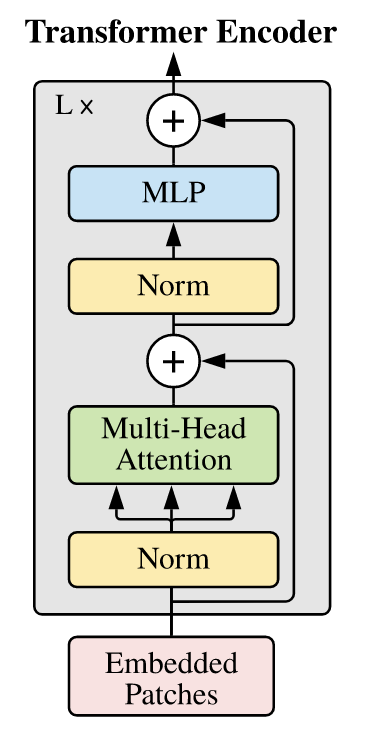

In [ ]:
class Block(nn.Module):
  def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
    super().__init__()

    # TODO
    self.embed_dim=embed_dim
    self.num_heads=num_heads

    self.norm1=nn.LayerNorm(embed_dim)
    self.attention=MultiHeadsSelfAttention(embed_dim,num_heads)
    self.norm2=nn.LayerNorm(embed_dim)
    self.mlp=nn.Sequential(
        nn.Linear(embed_dim,mlp_ratio*embed_dim),
        nn.GELU(),
        nn.Linear(mlp_ratio*embed_dim,embed_dim)
    )

  def forward(self, x):
    # TODO
    x=self.norm1(x)
    out_att=self.attention(x)
    x=x+out_att
    x=self.norm2(x)
    out_mlp=self.mlp(x)
    x=x+out_mlp


    return x

Block(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q6: Full ViT model

Now you need to build a ViT model based on what you coded in the previous questions. There are additional components that should be coded such as the Class token, Positional embedding and the classification head.

- Explain what is a Class token and why we use it? \\
- Explain whay is the the positional embedding (PE) and why it is important? \\

For PE, you can use a sinusoidal encoding (see below), or fully learned.


**Answers in the report.**

### Sinusoidal PE


In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(1,sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[0][i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

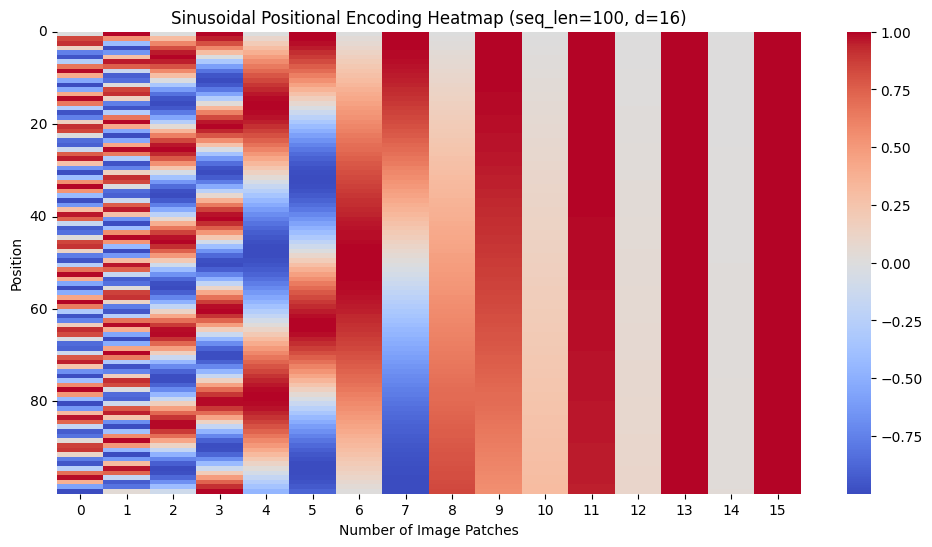

In [ ]:
import seaborn as sns
sequence_length = 100  # 假设图像被分成16个patch
embedding_dim = 16   # 假设嵌入维度为128

# 生成位置编码
positional_embeddings = get_positional_embeddings(sequence_length, embedding_dim).squeeze(0).numpy()

# 绘制热力图
plt.figure(figsize=(12, 6))
sns.heatmap(positional_embeddings, cmap="coolwarm", cbar=True)
plt.title(f"Sinusoidal Positional Encoding Heatmap (seq_len={sequence_length}, d={embedding_dim})")
plt.xlabel("Number of Image Patches")
plt.ylabel("Position")

plt.yticks(ticks=np.arange(0, sequence_length, 20), labels=np.arange(0, sequence_length, 20), rotation=0)
plt.show()

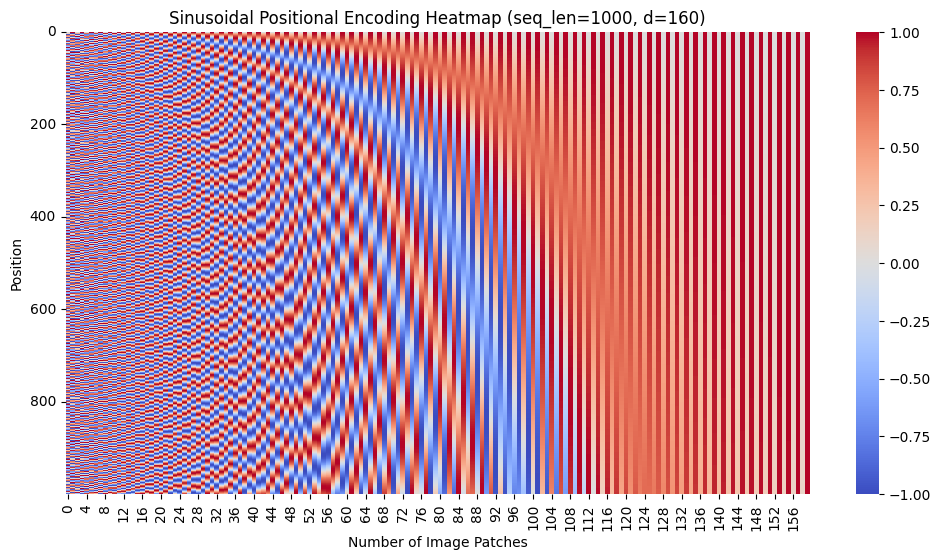

In [ ]:
sequence_length = 1000
embedding_dim = 160


positional_embeddings = get_positional_embeddings(sequence_length, embedding_dim).squeeze(0).numpy()


plt.figure(figsize=(12, 6))
sns.heatmap(positional_embeddings, cmap="coolwarm", cbar=True)
plt.title(f"Sinusoidal Positional Encoding Heatmap (seq_len={sequence_length}, d={embedding_dim})")
plt.xlabel("Number of Image Patches")
plt.ylabel("Position")

plt.yticks(ticks=np.arange(0, sequence_length, 200), labels=np.arange(0, sequence_length, 200), rotation=0)
plt.show()

In [ ]:
class ViT(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10):
    super().__init__()

    num_patches = (28 // patch_size) ** 2

    self.class_token = nn.Parameter(torch.zeros(1,1,embed_dim),requires_grad=False)
    self.pos_embed = nn.Parameter(get_positional_embeddings(num_patches + 1, embed_dim),requires_grad=False)
    self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

    blocks = []
    for _ in range(nb_blocks):
      blocks.append(
          Block(embed_dim)
      )
    self.blocks = nn.Sequential(*blocks)

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim,nb_classes) if nb_classes>0 else nn.Identity() # classifier head (fully connected layer)

  def forward(self, x):
    """
    x: torch.Tensor, shape [batch_size:B, in_channels:C, height:H, width:W]
    """
    x = self.patch_embed(x) ## image to patches [B,H*W,C]

    ## concatenating class token
    x = torch.cat((self.class_token.repeat(x.shape[0],1,1),x),dim=1) #[B,H*W+1,C]
    ## adding positional embedding
    x +=self.pos_embed.repeat(x.shape[0],1,1) #[B,H*W+1,C]
    ## forward in the transformer
    x = self.blocks(x)[:,0,:] # [B,C]

    ## Normalize the output
    x = self.norm(x) #[B,C]

    output = self.head(x) ## classification output [B,nb_classes]

    return output


ViT(128, 3, 7)(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 10])

# Q7: Experiment on MNIST!

A quick function to evaluate our model:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
@torch.no_grad()

def eval_model(model, loader):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.to(device), y.to(device)
    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

And run! Feel free to try other hyperparameters.

In [ ]:
epochs = 10


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def main(embed_size,patch_size,nb_blocks):
  model = ViT(embed_dim, nb_blocks, patch_size).cuda()

  opt = torch.optim.Adam(model.parameters())

  for epoch in range(epochs):
    train_loss = 0.
    for x, y in train_loader:
      x, y = x.cuda(), y.cuda()

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()

      train_loss += loss.item()

    print(f"--- Epoch {epoch} ---")
    print(f"Train loss: {train_loss / len(train_loader)}")
  acc = eval_model(model, test_loader)
  print(f"Test accuracy: {acc}")
embed_dim = 32
patch_size = 7
nb_blocks = 2
main(embed_dim,patch_size,nb_blocks)

--- Epoch 0 ---
Train loss: 0.6182141357075686
--- Epoch 1 ---
Train loss: 0.21945679856579442
--- Epoch 2 ---
Train loss: 0.1644181281423518
--- Epoch 3 ---
Train loss: 0.13422434144754652
--- Epoch 4 ---
Train loss: 0.11424944521203986
--- Epoch 5 ---
Train loss: 0.0994942014866165
--- Epoch 6 ---
Train loss: 0.09018048286430046
--- Epoch 7 ---
Train loss: 0.08110547502999747
--- Epoch 8 ---
Train loss: 0.07522549417449721
--- Epoch 9 ---
Train loss: 0.0679047670660179
Test accuracy: 96.83


# Experimental analysis
- Test different hyperparameters and explain how they affect the performance. In particular embed_dim, patch_size, and nb_blocks.
- Comment and discuss the final performance that you get. How to improve it?
-  What is the complexity of the transformer in terms of number of tokens? How you can improve it?

**Answers in the report.**

In [ ]:
epochs=10
def main(embed_size, patch_size, nb_blocks):
    model = ViT(embed_size, nb_blocks, patch_size).to(device)  # Changed .cuda() to .to(device)
    opt = torch.optim.Adam(model.parameters())

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        train_loss = 0.
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            opt.zero_grad()
            yhat = model(x)
            loss = F.cross_entropy(yhat, y)
            loss.backward()
            opt.step()

            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Evaluate on the test set
        test_loss = 0.
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            yhat = model(x)
            test_loss += F.cross_entropy(yhat, y).item()

        test_losses.append(test_loss / len(test_loader))

        # Evaluate accuracies
        train_acc = eval_model(model, train_loader)
        test_acc = eval_model(model, test_loader)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"--- Epoch {epoch} ---")
        print(f"Train loss: {train_loss / len(train_loader)}")
        print(f"Test loss: {test_loss / len(test_loader)}")
        print(f"Train accuracy: {train_acc}")
        print(f"Test accuracy: {test_acc}")
    return train_losses, test_losses, train_accuracies, test_accuracies




In [ ]:
def plot_plot(hyperparams, save_name=None):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax = ax.flatten()

    for opt, values in hyperparams.items():
        ax[0].plot(values[0], label=f"{opt}")
        ax[1].plot(values[1], label=f"{opt}")
        ax[2].plot(values[2], label=f"{opt}")
        ax[3].plot(values[3], label=f"{opt}")

    ax[0].set_title("Train loss / epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].set_ylim([0, 1])

    ax[1].set_title("Test loss / epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].set_ylim([0, 1])

    ax[2].set_title("Train Accuracy / epoch")
    ax[2].set_xlabel("Epoch")
    ax[2].set_ylabel("Accuracy")

    ax[3].set_title("Test Accuracy / epoch")
    ax[3].set_xlabel("Epoch")
    ax[3].set_ylabel("Accuracy")

    plt.legend()
    plt.tight_layout()
    if save_name:
        plt.savefig(f"{save_name}.pdf", dpi=100, bbox_inches="tight")
    plt.show()

## embed dim

--- Epoch 0 ---
Train loss: 0.993343412367774
Test loss: 0.39949021733637097
Train accuracy: 88.13
Test accuracy: 88.43
--- Epoch 1 ---
Train loss: 0.3247773524826524
Test loss: 0.24956926873213128
Train accuracy: 92.33
Test accuracy: 92.48
--- Epoch 2 ---
Train loss: 0.23506185758723888
Test loss: 0.19424346824990044
Train accuracy: 94.03
Test accuracy: 94.03
--- Epoch 3 ---
Train loss: 0.20176379004521156
Test loss: 0.18222047802343777
Train accuracy: 94.35
Test accuracy: 94.43
--- Epoch 4 ---
Train loss: 0.17982438901689515
Test loss: 0.15924741677892737
Train accuracy: 95.04
Test accuracy: 95.08
--- Epoch 5 ---
Train loss: 0.16350707284280105
Test loss: 0.1464763788353133
Train accuracy: 95.5
Test accuracy: 95.44
--- Epoch 6 ---
Train loss: 0.1530417038211182
Test loss: 0.16063841686973088
Train accuracy: 94.96
Test accuracy: 94.98
--- Epoch 7 ---
Train loss: 0.14266476290089997
Test loss: 0.13091805780047103
Train accuracy: 96.0
Test accuracy: 95.88
--- Epoch 8 ---
Train loss: 0.1

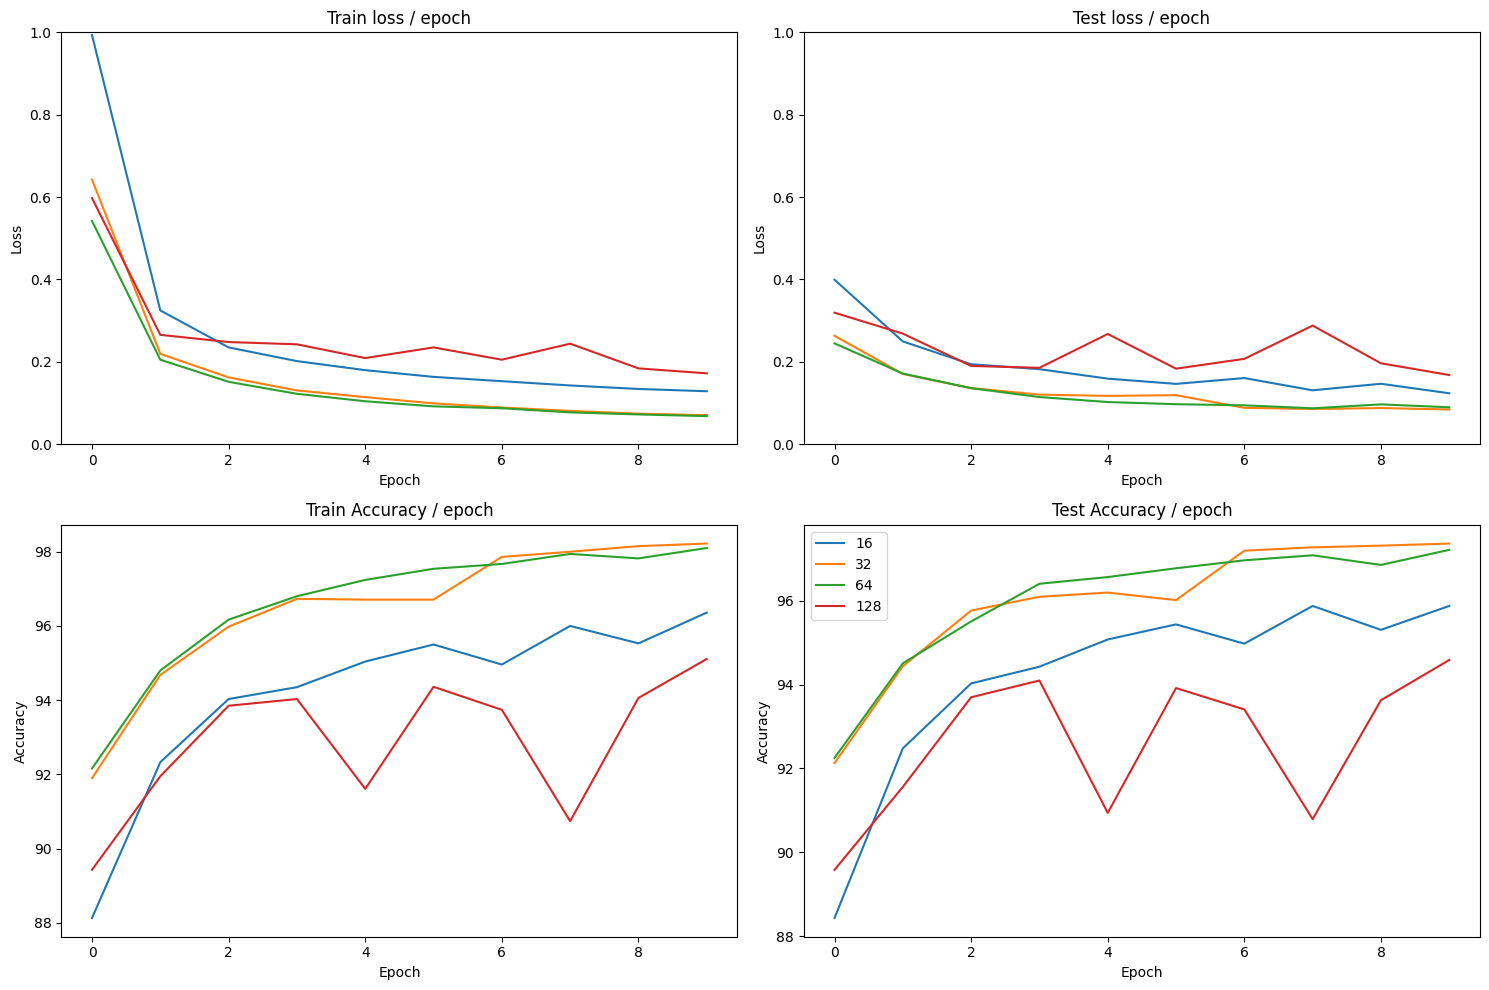

In [ ]:
embed_dim_list = [16, 32, 64, 128]  # Example embed sizes
plot_hyparams_embed_dims = {}

for embed_dim in embed_dim_list:
  stats=main(embed_dim, 7, 2)
  plot_hyparams_embed_dims[embed_dim] = stats

plot_plot(plot_hyparams_embed_dims, "embed_dim")

## patch_size

--- Epoch 0 ---
Train loss: 0.8670857860716675
Test loss: 0.43556030754801595
Train accuracy: 85.65
Test accuracy: 86.6
--- Epoch 1 ---
Train loss: 0.33429821944440097
Test loss: 0.24860397731012937
Train accuracy: 91.71
Test accuracy: 92.7
--- Epoch 2 ---
Train loss: 0.24017122705608035
Test loss: 0.21577223083829578
Train accuracy: 93.0
Test accuracy: 93.31
--- Epoch 3 ---
Train loss: 0.19812945121609327
Test loss: 0.2047515650621698
Train accuracy: 93.6
Test accuracy: 93.7
--- Epoch 4 ---
Train loss: 0.1714395294104939
Test loss: 0.1448384166541922
Train accuracy: 95.53
Test accuracy: 95.61
--- Epoch 5 ---
Train loss: 0.15355513055822742
Test loss: 0.14013872572657052
Train accuracy: 95.75
Test accuracy: 95.59
--- Epoch 6 ---
Train loss: 0.13958709388335885
Test loss: 0.12586159329814248
Train accuracy: 96.18
Test accuracy: 96.0
--- Epoch 7 ---
Train loss: 0.13186506197841436
Test loss: 0.14206121503552305
Train accuracy: 96.16
Test accuracy: 95.65
--- Epoch 8 ---
Train loss: 0.1180

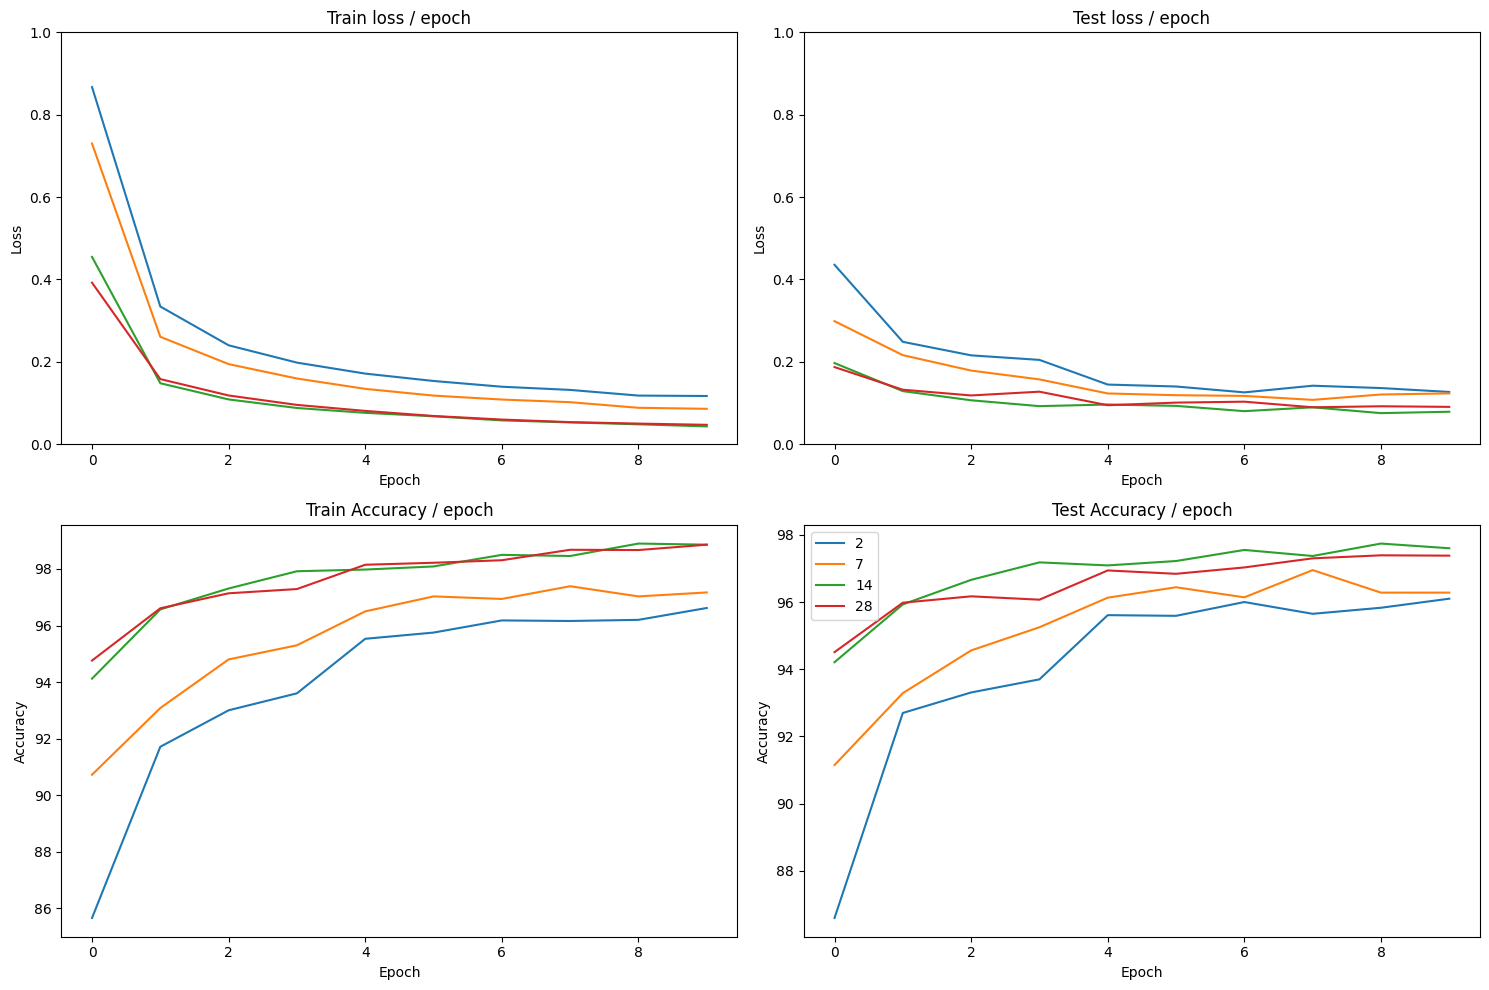

In [ ]:
patch_size_list = [2, 7, 14, 28] # Example patch sizes
plot_hyparams_patch_sizes = {}
for patch_size in patch_size_list:
  stats=main(32, patch_size, 2)
  plot_hyparams_patch_sizes[patch_size] = stats

plot_plot(plot_hyparams_patch_sizes, "patch_size")


##nb_blocks

In [ ]:
nb_blocks_list = [2, 4, 6, 8]  # Example number of blocks
plot_hyparams_nb_blocks = {}
for nb_blocks in nb_blocks_list:
  stats=main(32, 7, nb_blocks)
  plot_hyparams_nb_blocks[nb_blocks] = stats


--- Epoch 0 ---
Train loss: 0.6392342565473972
Test loss: 0.2663477843603756
Train accuracy: 92.11
Test accuracy: 92.03
--- Epoch 1 ---
Train loss: 0.22928228689186864
Test loss: 0.1766452152470622
Train accuracy: 94.8
Test accuracy: 94.79
--- Epoch 2 ---
Train loss: 0.16773657909810924
Test loss: 0.1345347576197001
Train accuracy: 96.16
Test accuracy: 95.68
--- Epoch 3 ---
Train loss: 0.13708219286808962
Test loss: 0.12490003454628625
Train accuracy: 96.36
Test accuracy: 96.02
--- Epoch 4 ---
Train loss: 0.11960304344196056
Test loss: 0.11482823435865532
Train accuracy: 96.93
Test accuracy: 96.17
--- Epoch 5 ---
Train loss: 0.10523624325802586
Test loss: 0.10676652112904983
Train accuracy: 97.32
Test accuracy: 96.76
--- Epoch 6 ---
Train loss: 0.09348807188430067
Test loss: 0.09937146341994027
Train accuracy: 97.5
Test accuracy: 96.65
--- Epoch 7 ---
Train loss: 0.08742109897421367
Test loss: 0.11127315407406681
Train accuracy: 97.34
Test accuracy: 96.49
--- Epoch 8 ---
Train loss: 0.

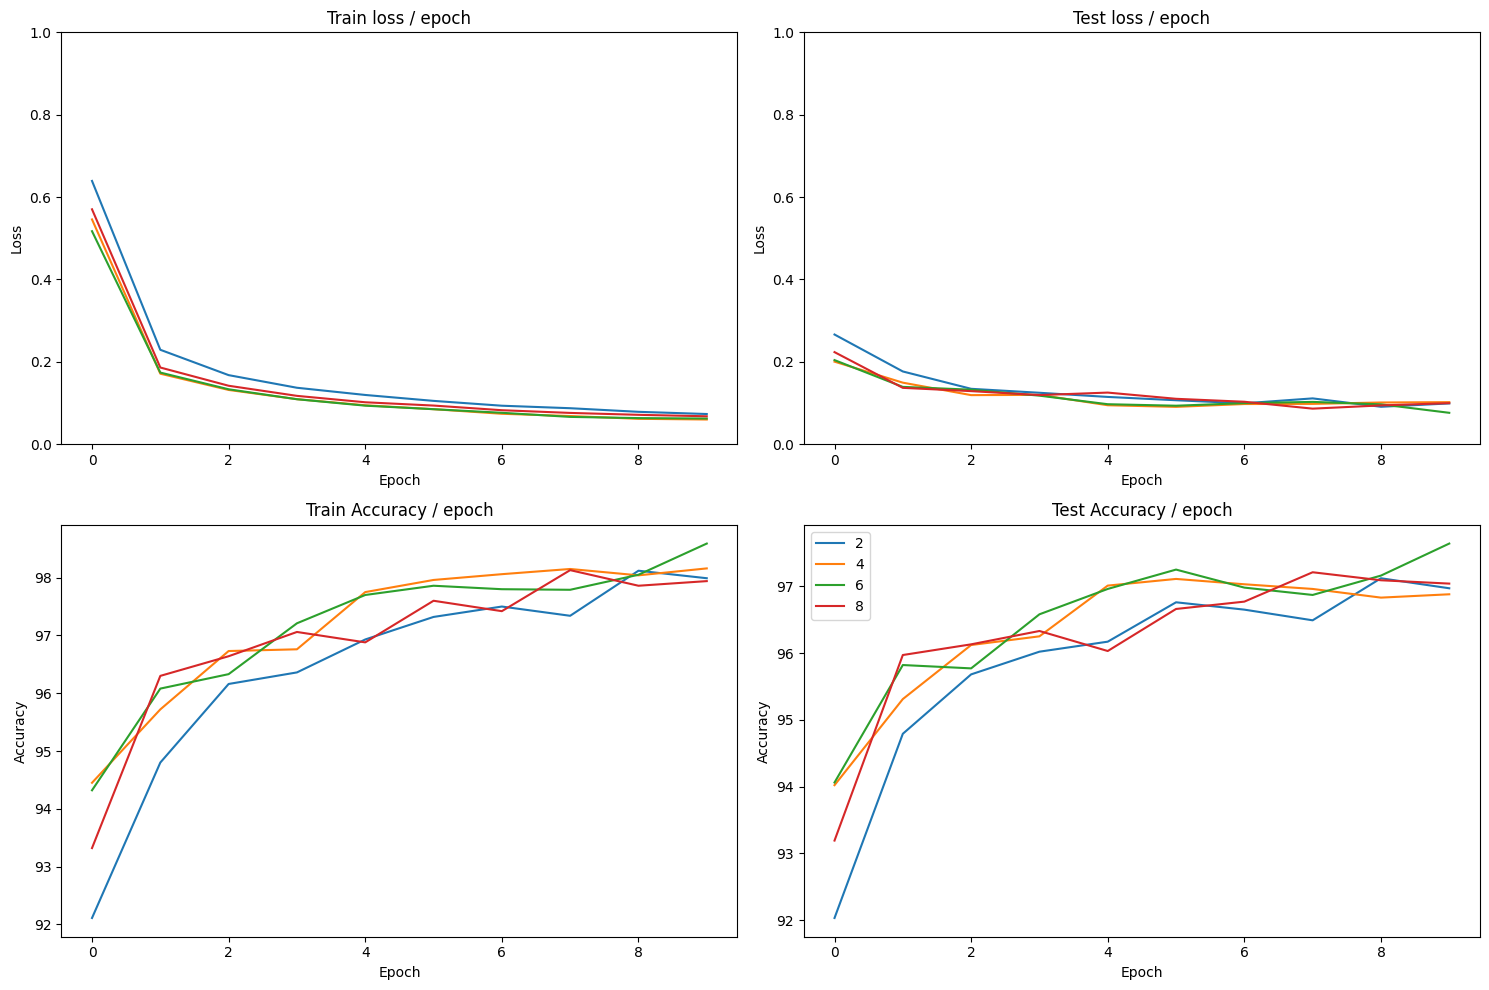

In [ ]:
plot_plot(plot_hyparams_nb_blocks, "nb_blocks")

# Q8: larger transformers

Try to use bigger transformer, for example the ViT-S from the timm library. Test with and without intialization from imagenet.

In [ ]:
!pip install timm

a) Load the model using the timm library without pretrained weights. Try to apply it directly on a tensor with the same MNIST images resolution. What it is the problem and why we have it? Explain if we have also such problem with CNNs. As ViT takes RGB images, the input tensor should have 3 channels.

**Answers in the report**

In [ ]:
import timm
# model = timm.list_models(pretrained=False)
# print(model)
model=timm.create_model('vit_base_patch16_224',pretrained=False,num_classes=10)


In [ ]:
try:
    model(torch.randn(32, 1, 28, 28))
except AssertionError as err:
    print(err)

Input height (28) doesn't match model (224).


In [ ]:
x = torch.randn(32, 1, 28, 28)
x = x.repeat(1,3,8,8) # adapt number of channels to fit in ViT
model(x).shape

torch.Size([32, 10])

learning from scratch

In [ ]:
model.cuda()
@torch.no_grad()
def eval_model(model, loader, num_channels=1):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    x = x.repeat(1,3,8,8) # adapt number of channels to fit in ViT
    # print(x.shape)
    yhat = model(x)
    # print(yhat.shape)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

In [ ]:
def main_vits_from_scratch(model):

    # Define the optimizer
    opt = torch.optim.Adam(model.parameters())

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        train_loss = 0.
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            opt.zero_grad()
            x=x.repeat(1,3,8,8) # Adapt number of channels to fit in ViT
            yhat = model(x)
            loss = F.cross_entropy(yhat, y)
            loss.backward()
            opt.step()

            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Evaluate on the test set
        test_loss = 0.
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            x=x.repeat(1,3,8,8)  # Adapt number of channels to fit in ViT
            yhat = model(x)
            test_loss += F.cross_entropy(yhat, y).item()

        test_losses.append(test_loss / len(test_loader))

        # Evaluate accuracies
        train_acc = eval_model(model, train_loader, num_channels=3)
        test_acc = eval_model(model, test_loader, num_channels=3)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"--- Epoch {epoch + 1} ---")
        print(f"Train loss: {train_loss / len(train_loader)}")
        print(f"Test loss: {test_loss / len(test_loader)}")
        print(f"Train accuracy: {train_acc}")
        print(f"Test accuracy: {test_acc}")

    return train_losses, test_losses, train_accuracies, test_accuracies

In [ ]:
def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies):
    """Plot training and test loss and accuracy over epochs."""

    epochs_range = range(1, epochs + 1)

    # Plotting Train and Test Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs_range, test_losses, label='Test Loss', marker='o')
    plt.title('Train and Test Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plotting Train and Test Accuracy
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs_range, test_accuracies, label='Test Accuracy', marker='o')
    plt.title('Train and Test Accuracy vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid()

    plt.tight_layout()  # Adjust subplots to fit into the figure area.
    plt.show()

--- Epoch 1 ---
Train loss: 2.080651089072482
Test loss: 1.843503331836266
Train accuracy: 30.38
Test accuracy: 30.2
--- Epoch 2 ---
Train loss: 1.6409018504848358
Test loss: 1.2352101923544196
Train accuracy: 56.29
Test accuracy: 56.33
--- Epoch 3 ---
Train loss: 1.2420301793226556
Test loss: 1.5328003741517853
Train accuracy: 44.77
Test accuracy: 45.91
--- Epoch 4 ---
Train loss: 1.2171582682554656
Test loss: 0.9462418790105023
Train accuracy: 65.77
Test accuracy: 66.25
--- Epoch 5 ---
Train loss: 0.9026477225045405
Test loss: 0.806427897531775
Train accuracy: 71.83
Test accuracy: 72.73
--- Epoch 6 ---
Train loss: 0.9008092837038834
Test loss: 0.7346661596358577
Train accuracy: 75.0
Test accuracy: 75.25
--- Epoch 7 ---
Train loss: 0.7589487488081714
Test loss: 0.6921882233287715
Train accuracy: 76.14
Test accuracy: 75.99
--- Epoch 8 ---
Train loss: 0.6634557491807795
Test loss: 0.5433204847423336
Train accuracy: 82.32
Test accuracy: 82.44
--- Epoch 9 ---
Train loss: 0.577207671871571

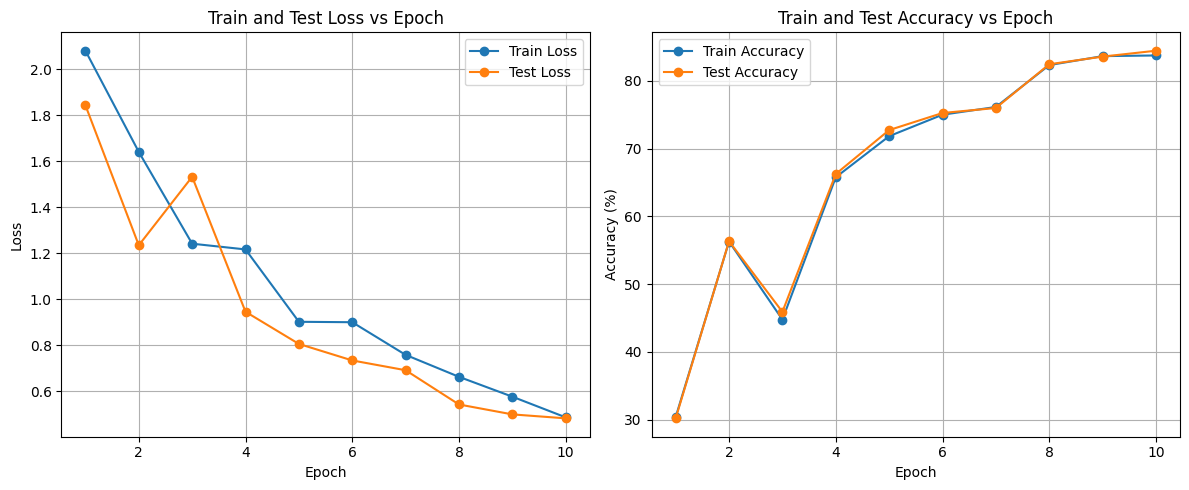

In [ ]:
stats=main_vits_from_scratch(model)
plot_metrics(*stats)

b) There is a trick in timm that allows to use pretrained models with different image resolution and number of classes. Try to reload the model to be able to use on MNIST images:

In [ ]:
# data_cfg=timm.data.resolve_data_config(pretrained_cfg=model.pretrained_cfg)
# data_cfg
# # to find out which transformations were used for a given pretrained model
model = timm.create_model('vit_base_patch16_224', pretrained=True, pretrained_cfg_overlay={'input_size':(3, 28, 28)}, num_classes=10)
model(torch.randn(32,3,28,28)).shape

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

torch.Size([32, 10])

c) redo the training with the pretrained ViT-S





In [ ]:
model=model.cuda()

In [ ]:
@torch.no_grad()
def eval_model(model, loader, num_channels=1):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    x = x.repeat(1,3,1,1) # adapt number of channels to fit in ViT
    # print(x.shape)
    yhat = model(x)
    # print(yhat.shape)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

In [ ]:
def main_vits(model):

    # Define the optimizer
    opt = torch.optim.Adam(model.parameters())

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        train_loss = 0.
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            opt.zero_grad()
            x = x.repeat(1, 3, 1, 1)  # Adapt number of channels to fit in ViT
            yhat = model(x)
            loss = F.cross_entropy(yhat, y)
            loss.backward()
            opt.step()

            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Evaluate on the test set
        test_loss = 0.
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            x = x.repeat(1, 3, 1, 1)  # Adapt number of channels to fit in ViT
            yhat = model(x)
            test_loss += F.cross_entropy(yhat, y).item()

        test_losses.append(test_loss / len(test_loader))

        # Evaluate accuracies
        train_acc = eval_model(model, train_loader, num_channels=3)
        test_acc = eval_model(model, test_loader, num_channels=3)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"--- Epoch {epoch + 1} ---")
        print(f"Train loss: {train_loss / len(train_loader)}")
        print(f"Test loss: {test_loss / len(test_loader)}")
        print(f"Train accuracy: {train_acc}")
        print(f"Test accuracy: {test_acc}")

    return train_losses, test_losses, train_accuracies, test_accuracies

--- Epoch 1 ---
Train loss: 1.1031732547130666
Test loss: 0.5812511202655261
Train accuracy: 80.49
Test accuracy: 81.27
--- Epoch 2 ---
Train loss: 0.5566662450843274
Test loss: 0.47586960279488866
Train accuracy: 84.03
Test accuracy: 84.33
--- Epoch 3 ---
Train loss: 0.46714922779404533
Test loss: 0.4192764352582678
Train accuracy: 86.31
Test accuracy: 86.47
--- Epoch 4 ---
Train loss: 0.41696634278622774
Test loss: 0.3832722955112216
Train accuracy: 87.56
Test accuracy: 87.4
--- Epoch 5 ---
Train loss: 0.38741834204334186
Test loss: 0.34983119095050835
Train accuracy: 88.86
Test accuracy: 88.34
--- Epoch 6 ---
Train loss: 0.37212173240398294
Test loss: 0.36970802641744854
Train accuracy: 88.25
Test accuracy: 88.1
--- Epoch 7 ---
Train loss: 0.3605706334940152
Test loss: 0.35149099913579
Train accuracy: 89.23
Test accuracy: 88.64
--- Epoch 8 ---
Train loss: 0.3516498139100288
Test loss: 0.3508324657059923
Train accuracy: 89.3
Test accuracy: 88.59
--- Epoch 9 ---
Train loss: 0.33789840

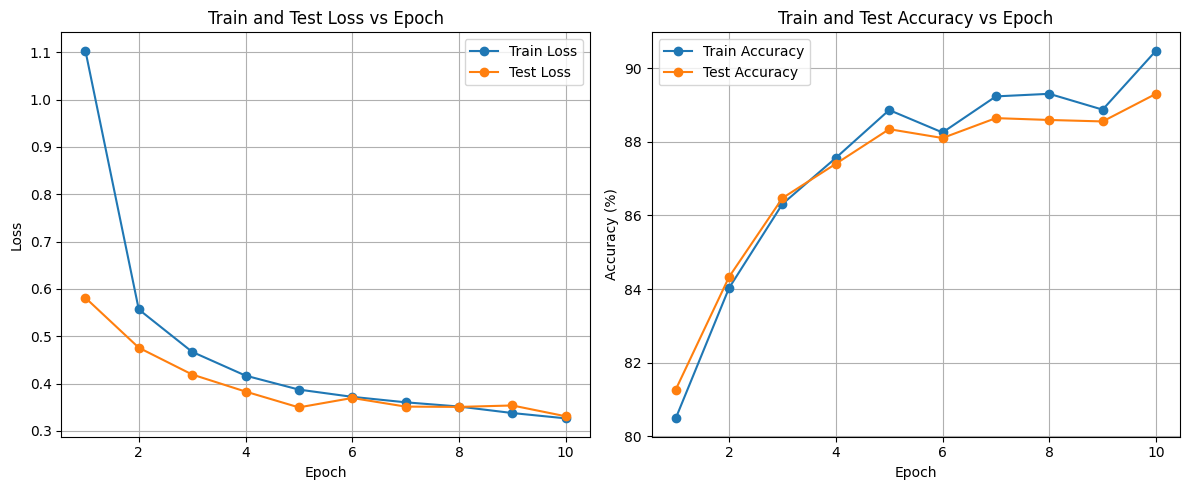

In [ ]:
stats=main_vits(model)
plot_metrics(*stats)

c) redo the training but with the ViT-S pretrained on ImageNet

redo the training on a smaller dataset

In [ ]:
model_new = timm.create_model('vit_small_patch16_224', pretrained=True,pretrained_cfg_overlay={'input_size':(3, 28, 28)}, num_classes=10).cuda()

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

--- Epoch 1 ---
Train loss: 0.5842380621222291
Test loss: 0.36244763103844246
Train accuracy: 88.66
Test accuracy: 87.98
--- Epoch 2 ---
Train loss: 0.3329742836481981
Test loss: 0.294199241678926
Train accuracy: 91.36
Test accuracy: 90.23
--- Epoch 3 ---
Train loss: 0.290271238874652
Test loss: 0.272090476053425
Train accuracy: 92.45
Test accuracy: 91.12
--- Epoch 4 ---
Train loss: 0.25535022699311855
Test loss: 0.3049452939554106
Train accuracy: 92.13
Test accuracy: 89.76
--- Epoch 5 ---
Train loss: 0.2348404628699268
Test loss: 0.28158151726179487
Train accuracy: 93.18
Test accuracy: 90.92
--- Epoch 6 ---
Train loss: 0.2216960788488007
Test loss: 0.27471579516990274
Train accuracy: 93.75
Test accuracy: 91.14
--- Epoch 7 ---
Train loss: 0.20761499414121165
Test loss: 0.27503964618508575
Train accuracy: 94.14
Test accuracy: 91.18
--- Epoch 8 ---
Train loss: 0.19679993385476852
Test loss: 0.27331462714679633
Train accuracy: 94.44
Test accuracy: 91.0
--- Epoch 9 ---
Train loss: 0.183059

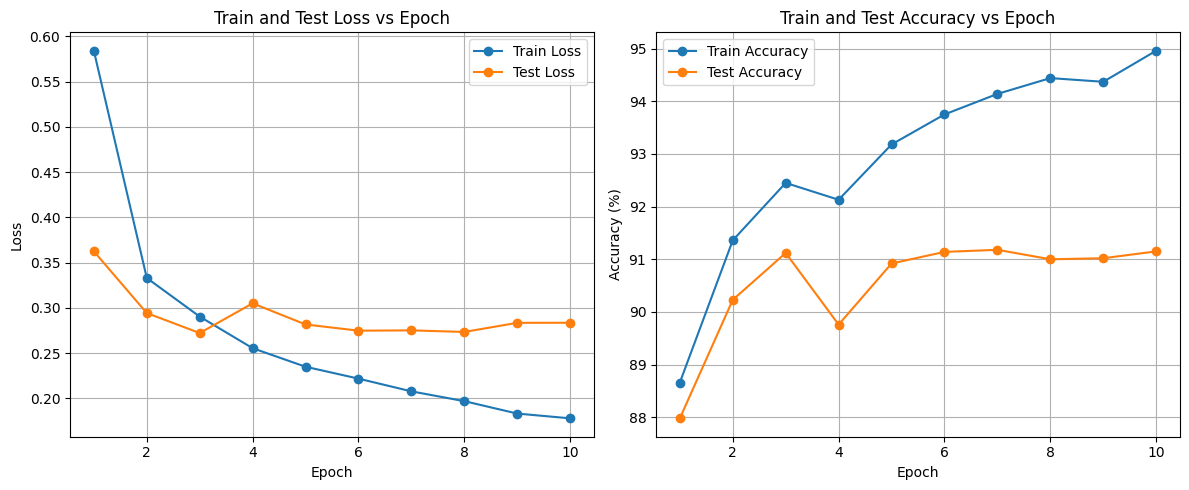

In [ ]:
stats=main_vits(model_new)
plot_metrics(*stats)

d) Comment the final results and provide some ideas on how to make transformer work on small datasets. You can take inspiration from some recent work.

**Answers in the report.**